In [1]:
import functools
from pathlib import Path

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
def open_image(path:Path) -> jnp.ndarray:
    img = Image.open(path)
    imgs = []
    for i in range(img.n_frames):
        img.seek(i)
        imgs.append(jnp.array(img))

    return jnp.stack(imgs, axis=0)

image = open_image("../data/yale/light_field_image.tif")[0]
measured_psf = open_image("../data/yale/measured_psf.tif")
mirrored_psf = jax.vmap(jnp.fliplr)(measured_psf)
mirrored_psf = jax.vmap(jnp.flipud)(mirrored_psf)

image.shape, measured_psf.shape

((2048, 2048), (41, 2048, 2048))

In [3]:
image /= image.max()
measured_psf /= measured_psf.sum(axis=(1, 2), keepdims=True)
mirrored_psf /= mirrored_psf.sum(axis=(1, 2), keepdims=True)

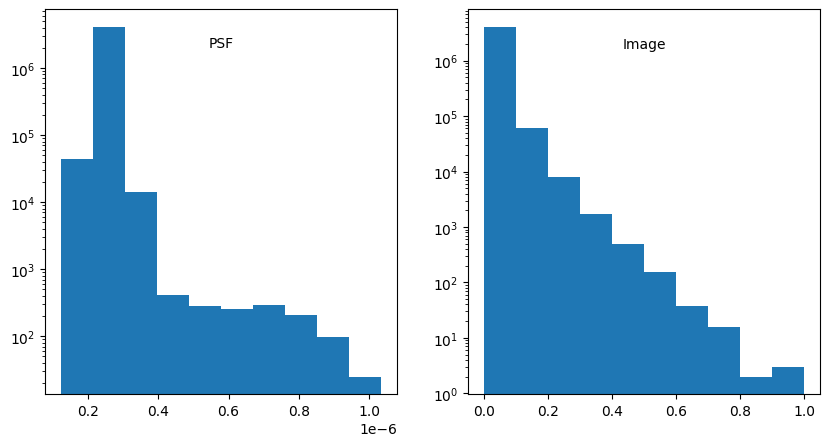

In [5]:
f, (ax_psf, ax_img) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax_psf.text(0.5, 0.9, "PSF", horizontalalignment="center", transform=ax_psf.transAxes)
ax_psf.hist(measured_psf[0].flatten(), log=True)
ax_img.text(0.5, 0.9, "Image", horizontalalignment="center", transform=ax_img.transAxes)
ax_img.hist(image.flatten(), log=True)
plt.show()

In [6]:
@functools.partial(jax.vmap, in_axes=(0, 0))
def mapped_conv_nn(x:jnp.ndarray, y:jnp.ndarray)->jnp.ndarray:
    return jsp.signal.fftconvolve(x, y, mode="same")


@functools.partial(jax.vmap, in_axes=(None, 0))
def mapped_conv_1n(x:jnp.ndarray, y:jnp.ndarray)->jnp.ndarray:
    return jsp.signal.fftconvolve(x, y, mode="same")


def broadcast_mult_RL_step_f(
    img_estimate:jnp.ndarray, # [n, h, w]
    img:jnp.ndarray, # [h, w]
    psf:jnp.ndarray, # [n, h, w]
    psf_m:jnp.ndarray, # [n, h, w]
)-> jnp.ndarray:
    denom = mapped_conv_nn(img_estimate, psf).sum(axis=0)
    return img_estimate * mapped_conv_1n(img / denom, psf_m)

In [7]:
run_f = jax.jit(lambda x: broadcast_mult_RL_step_f(x, image, measured_psf, mirrored_psf))

In [8]:
guess = jnp.ones_like(measured_psf) * 0.5

In [25]:
for _  in range(10):
    guess = run_f(guess)

In [26]:
img = Image.fromarray(np.array(guess[0]))
img.save(
    "test.tif",
    format="tiff",
    append_images=[Image.fromarray(np.array(guess[i])) for i in range(1, len(guess))],
    save_all=True
)

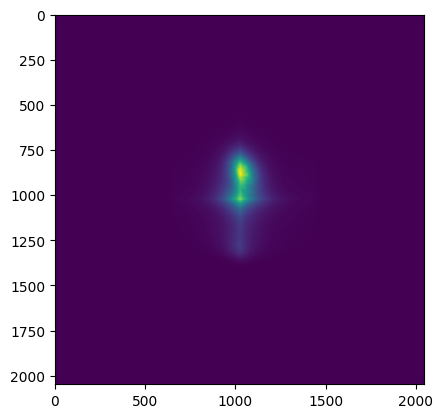

In [28]:
plt.imshow(guess[0])

let's try without the total sum in the divisor

In [5]:
@functools.partial(jax.vmap, in_axes=(0, None, 0, 0))
def broadcast_mult_RL_2D_step_f(
    img_estimate:jnp.ndarray, # [h, w]
    img:jnp.ndarray, # [h, w]
    psf:jnp.ndarray, # [h, w]
    psf_m:jnp.ndarray, # [h, w]
)-> jnp.ndarray:
    denom = jsp.signal.fftconvolve(img_estimate, psf, mode="same")
    return img_estimate * jsp.signal.fftconvolve(img / denom, psf_m, mode="same")

run_f = jax.jit(
    lambda x: broadcast_mult_RL_2D_step_f(x, image, measured_psf, mirrored_psf),
    backend="gpu",
)

In [6]:
guess = jnp.ones_like(measured_psf) * 0.5

In [13]:
for i in range(100):
    guess = run_f(guess)
guess.block_until_ready().shape

(41, 2048, 2048)

In [14]:
img = Image.fromarray(np.array(guess[0]))
img.save(
    "test.tif",
    format="tiff",
    append_images=[Image.fromarray(np.array(guess[i])) for i in range(1, len(guess))],
    save_all=True
)

In [46]:
idx = 20

psf = measured_psf[idx]
psf_m = jnp.flipud(mirrored_psf[idx])

run_f = jax.jit(lambda x: broadcast_mult_RL_2D_step_f(x, image, psf, psf_m))

In [51]:
for i in range(20):
    guess = run_f(guess)

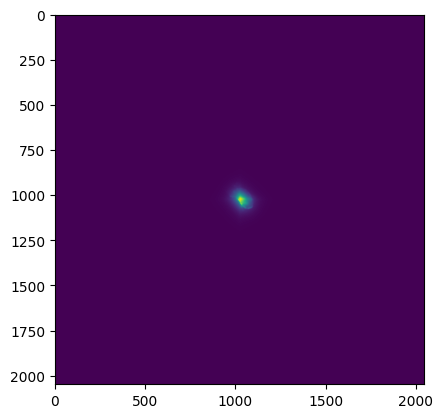

In [52]:
Image.fromarray(np.array(guess)).save("test2.tif")
plt.imshow(guess)